In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from models import *
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

ss_X_dep = StandardScaler()
ss_y_dep = StandardScaler()

def rmse(y1, y2):
    return np.sqrt(mean_squared_error(y1, y2))

In [2]:
def LSTM_FC_prediction(X, Y, X_test=None, iters=20000, learning_rate=1e-4, dropout_prob=0.5):
    if dropout_prob > 1. or dropout_prob < 0.:
        raise Exception('Dropout level must be in interval [0, 1]')
    print("learning rate:", learning_rate)
    print("dropout:", dropout_prob)
    print("iterations:", iters)
    num_month = Y.shape[0]
    input_shape = X.shape[1]
    print('num_month:', num_month)
    print('variable size:', input_shape)
    model = LSTM_FC_Model(num_input=input_shape, num_hidden=[40], num_output=1)

    Loss = []
    print('Start training......')
    for iter in range(iters + 1):
        loss = model.fit(X, Y, learning_rate, dropout_prob)
        Loss.append(loss)
        if iter % 1000 == 0:
            print("iteration: %s, loss: %s" % (iter, loss))

    # Saving model
    model.save_model_params('checkpoints/LSTM_FC_CKPT')

    print('Start predicting......')
    Y_test = model.predict(X_test)
    print('Done.')
    return Y_test

# Train and validate LSTM_FC Model in dataset.

In [3]:
# Load data
data = pd.read_csv('data/demo.csv')
Inputs = data.drop('Year', axis=1).drop('Depth', axis=1)
Outputs = data['Depth']

Inputs = Inputs.as_matrix()
Outputs = Outputs.as_matrix().reshape(-1, 1)

# First 12 years of data
X_train_dep = Inputs[0:144]
y_train_dep = Outputs[0:144]

# Last two years of data
X_test_dep = Inputs[144:]

print("X_train_dep shape", X_train_dep.shape)
print("y_train_dep shape", y_train_dep.shape)
print("X_test_dep shape", X_test_dep.shape)

X = np.concatenate([X_train_dep, X_test_dep], axis=0)

# Standardization
X = ss_X_dep.fit_transform(X)

# First 12 years of data
X_train_dep_std = X[0:144]
y_train_dep_std = ss_y_dep.fit_transform(y_train_dep)

# All 14 years of data
X_test_dep_std  = X

print("X_train_dep_std shape", X_train_dep_std.shape)
print("y_train_dep_std shape", y_train_dep_std.shape)
print("X_test_dep_std shape", X_test_dep_std.shape)

y_pred_dep = LSTM_FC_prediction(X_train_dep_std, y_train_dep_std, X_test_dep_std, iters=14000, learning_rate=1e-4)
y_pred_dep = ss_y_dep.inverse_transform(y_pred_dep[144:])

X_train_dep shape (144, 5)
y_train_dep shape (144, 1)
X_test_dep shape (24, 5)
X_train_dep_std shape (144, 5)
y_train_dep_std shape (144, 1)
X_test_dep_std shape (168, 5)
learning rate: 0.0001
dropout: 0.5
iterations: 14000
num_month: 144
variable size: 5
Build LSTM_FC Model......


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Start training......
iteration: 0, loss: 371.0372087489539
iteration: 1000, loss: 134.1267558632824
iteration: 2000, loss: 90.1222537629338
iteration: 3000, loss: 77.63701763793665
iteration: 4000, loss: 66.41027382549018
iteration: 5000, loss: 51.01219022901203
iteration: 6000, loss: 47.164085877529835
iteration: 7000, loss: 51.9101562927477
iteration: 8000, loss: 41.27283749506584
iteration: 9000, loss: 43.21454358961822
iteration: 10000, loss: 43.26276443680515
iteration: 11000, loss: 38.1480625866977
iteration: 12000, loss: 34.393987462582146
iteration: 13000, loss: 31.22542563962359
iteration: 14000, loss: 28.820937470184624
Start predicting......
Done!


The value of R-squared of water table depth is  0.6699877233397822
The value of Root mean squared error of water table depth is  0.9449295363104716


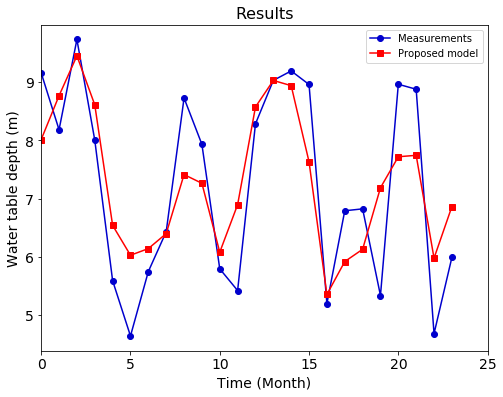

In [4]:
print('The value of R-squared of water table depth is ', r2_score(Outputs[144:], y_pred_dep))
print('The value of Root mean squared error of water table depth is ', rmse(Outputs[144:], y_pred_dep))

f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax1.plot(Outputs[144:], color="mediumblue", linestyle="-", marker="o", linewidth=1.5, label="Measurements")
ax1.plot(y_pred_dep, color="r", linestyle="-", marker="s", linewidth=1.5, label="Proposed model")

ax1.set_title('Results', fontsize=16, fontweight='normal')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
plt.legend(loc='upper right')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('Time (Month)', fontsize=14)
plt.ylabel('Water table depth (m)', fontsize=14)
plt.xlim(0, 25)

plt.show()

# Load Model parameters from checkpoints.

In [5]:
model_restore = LSTM_FC_Model(num_input=5, num_hidden=[40], num_output=1)
# Loading model
print('Start loading model......')
model_restore.load_model_params('checkpoints/LSTM_FC_CKPT')
print('Model restored.')
print('Start predicting......')
y_pred_dep_ = model_restore.predict(X_test_dep_std)
y_pred_dep_ = ss_y_dep.inverse_transform(y_pred_dep_[144:])
print('Done.')

Build LSTM_FC Model......
Start loading model......
Model restored.
Start predicting......
Done.


the value of R-squared of Evaporation is  0.6699877233397822
the value of Root mean squared error of Evaporation is  0.9449295363104716


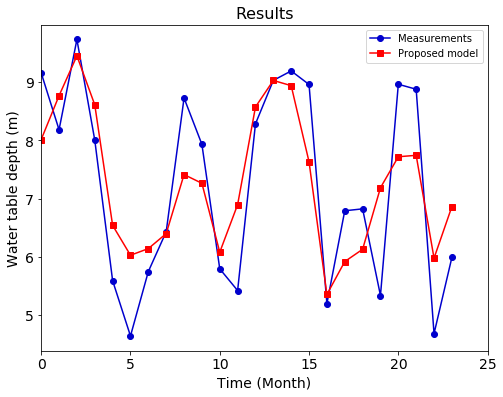

In [6]:
print('the value of R-squared of Evaporation is ', r2_score(Outputs[144:], y_pred_dep_))
print('the value of Root mean squared error of Evaporation is ', rmse(Outputs[144:], y_pred_dep_))


f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax1.plot(Outputs[144:], color="mediumblue", linestyle="-", marker="o", linewidth=1.5, label="Measurements")
ax1.plot(y_pred_dep_, color="r", linestyle="-", marker="s", linewidth=1.5, label="Proposed model")

ax1.set_title('Results', fontsize=16, fontweight='normal')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
plt.legend(loc='upper right')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('Time (Month)', fontsize=14)
plt.ylabel('Water table depth (m)', fontsize=14)
plt.xlim(0, 25)

plt.show()